<a href="https://colab.research.google.com/github/TAEWOOYOON/SkillTreePython-DeepLearning/blob/main/04.Paper-with-code/ch04_05_WaveNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ch04.05 Wave Net

* 날짜: 2022.08.23
* 이름: 윤태우

## 학습내용
    - Audio data에 대해 이해한다.
    - 머신러닝 방법으로 접근하여 문제를 해결해 본다.
    - 딥러닝 네트워크를 이용해 문제를 해결한다.
    - waveNet, yamNet 등 딥러닝 알고리즘을 적용한다.



In [126]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [127]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import sys, os
import tensorflow as tf
from tensorflow.keras import models, layers, utils, losses, optimizers
import seaborn as sns
sys.path.append('/content/drive/MyDrive/script')

## 데이터셋 - Kaggle GTZAN Dataset 
---

https://www.kaggle.com/datasets/andradaolteanu/gtzan-dataset-music-genre-classification



### **| kaggle 데이터 연동**


1. kaggle 로그인 - my account - API Create New Api Token - `kaggle.json` 파일 다운로드
2. Drive에 저장해 놓는것을 권장
3. kaggle 패키지 다운로드
```
! pip install kaggle
```
4. 권한 변경
```
! chmod 600 `드라이브 파일 경로`
```
5. `~/` 위치에 복사
```
! cp `드라이브 파일 경로` ~/.kaggle/
```

6. 데이터셋 다운로드
```
! kaggle datasets download 데이터주소
```

In [128]:
! pip install kaggle

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [129]:
! chmod 600 /content/drive/MyDrive/script/kaggle.json

In [130]:
ls -a /root

./   .bashrc*  .config/   .jupyter/  .keras/  .npm/     .tmux.conf*
../  .cache/   .ipython/  .kaggle/   .local/  .profile  .wget-hsts


In [131]:
mkdir ~/.kaggle/

mkdir: cannot create directory ‘/root/.kaggle/’: File exists


In [132]:
! cp /content/drive/MyDrive/script/kaggle.json ~/.kaggle/kaggle.json

In [133]:
! kaggle datasets download andradaolteanu/gtzan-dataset-music-genre-classification

gtzan-dataset-music-genre-classification.zip: Skipping, found more recently modified local copy (use --force to force download)


In [134]:
! unzip /content/gtzan-dataset-music-genre-classification.zip

Archive:  /content/gtzan-dataset-music-genre-classification.zip
replace Data/features_30_sec.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

### **| EDA**

In [135]:
df = pd.read_csv('/content/Data/features_30_sec.csv')
print(df.shape)
df.head()

(1000, 60)


,filename,length,chroma_stft_mean,chroma_stft_var,rms_mean,rms_var,spectral_centroid_mean,spectral_centroid_var,spectral_bandwidth_mean,spectral_bandwidth_var,...,mfcc16_var,mfcc17_mean,mfcc17_var,mfcc18_mean,mfcc18_var,mfcc19_mean,mfcc19_var,mfcc20_mean,mfcc20_var,label
0,blues.00000.wav,661794,0.350088,0.088757,0.130228,0.002827,1784.165850,129774.064525,2002.449060,85882.761315,...,52.420910,-1.690215,36.524071,-0.408979,41.597103,-2.303523,55.062923,1.221291,46.936035,blues
1,blues.00001.wav,661794,0.340914,0.094980,0.095948,0.002373,1530.176679,375850.073649,2039.036516,213843.755497,...,55.356403,-0.731125,60.314529,0.295073,48.120598,-0.283518,51.106190,0.531217,45.786282,blues
2,blues.00002.wav,661794,0.363637,0.085275,0.175570,0.002746,1552.811865,156467.643368,1747.702312,76254.192257,...,40.598766,-7.729093,47.639427,-1.816407,52.382141,-3.439720,46.639660,-2.231258,30.573025,blues
3,blues.00003.wav,661794,0.404785,0.093999,0.141093,0.006346,1070.106615,184355.942417,1596.412872,166441.494769,...,44.427753,-3.319597,50.206673,0.636965,37.319130,-0.619121,37.259739,-3.407448,31.949339,blues
4,blues.00004.wav,661794,0.308526,0.087841,0.091529,0.002303,1835.004266,343399.939274,1748.172116,88445.209036,...,86.099236,-5.454034,75.269707,-0.916874,53.613918,-4.404827,62.910812,-11.703234,55.195160,blues


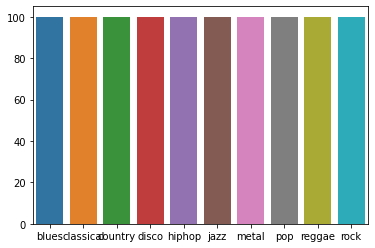

In [136]:
# 예측해야할 클래스

class_count = df['label'].value_counts()
sns.barplot(x=class_count.index, y = class_count.values)

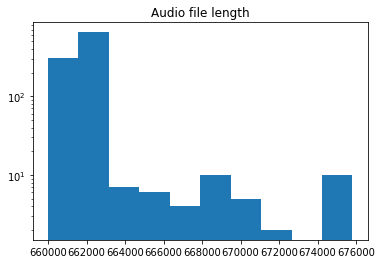

In [137]:
# 음성 파일의 길이
plt.title('Audio file length')
plt.hist(df['length'], log = True)
plt.show()

feature counts :  57


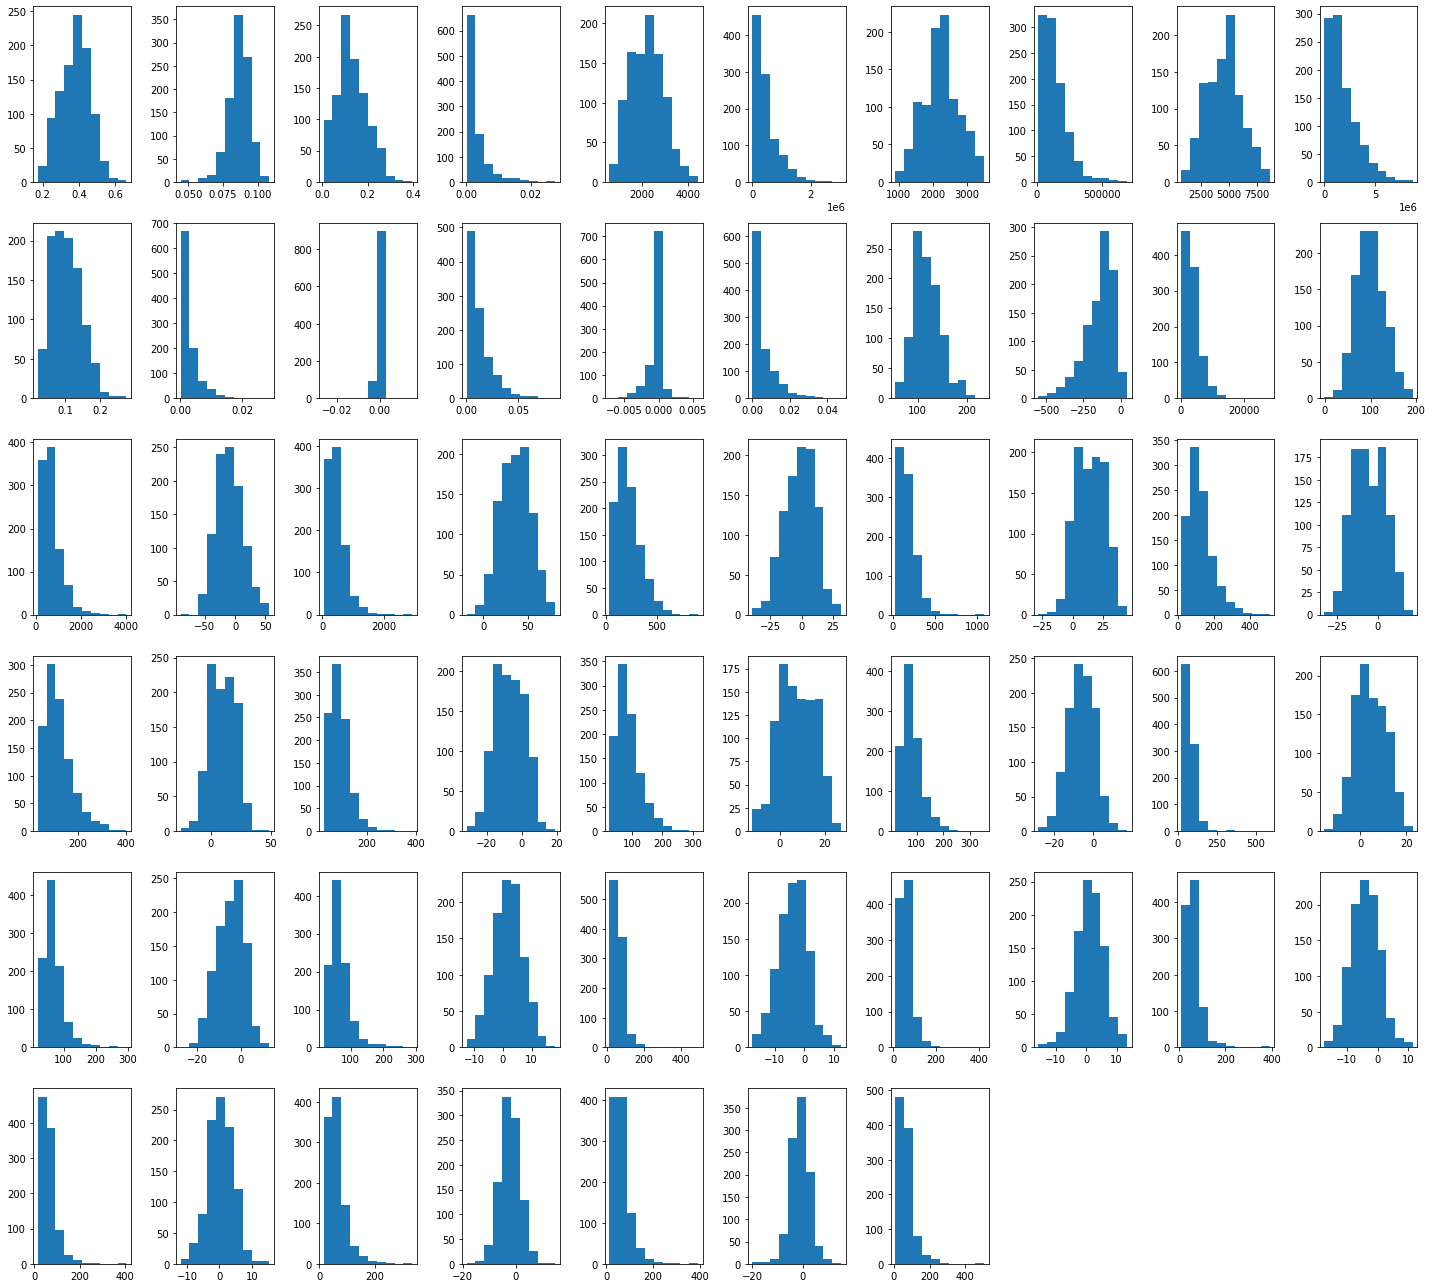

In [138]:
# 특성 분포
print('feature counts : ',len(df.columns[2:-1]))
plt.figure(figsize=(20,18))
for i, col in enumerate(df.columns[2:-1]) :
  plt.subplot(6,10,i+1)
  plt.hist(df[col])
  plt.tight_layout()

## 머신러닝 접근 방법 (features)
---

### **| 파라미터 추가**


### **| 전처리**


In [139]:
# label encoding ( blues, disco, ...) -> (0,1,....)
from sklearn import preprocessing

le = preprocessing.LabelEncoder()
df['le_label'] = le.fit_transform(df['label'])
print(le.classes_)
df.head()

['blues' 'classical' 'country' 'disco' 'hiphop' 'jazz' 'metal' 'pop'
 'reggae' 'rock']


,filename,length,chroma_stft_mean,chroma_stft_var,rms_mean,rms_var,spectral_centroid_mean,spectral_centroid_var,spectral_bandwidth_mean,spectral_bandwidth_var,...,mfcc17_mean,mfcc17_var,mfcc18_mean,mfcc18_var,mfcc19_mean,mfcc19_var,mfcc20_mean,mfcc20_var,label,le_label
0,blues.00000.wav,661794,0.350088,0.088757,0.130228,0.002827,1784.165850,129774.064525,2002.449060,85882.761315,...,-1.690215,36.524071,-0.408979,41.597103,-2.303523,55.062923,1.221291,46.936035,blues,0
1,blues.00001.wav,661794,0.340914,0.094980,0.095948,0.002373,1530.176679,375850.073649,2039.036516,213843.755497,...,-0.731125,60.314529,0.295073,48.120598,-0.283518,51.106190,0.531217,45.786282,blues,0
2,blues.00002.wav,661794,0.363637,0.085275,0.175570,0.002746,1552.811865,156467.643368,1747.702312,76254.192257,...,-7.729093,47.639427,-1.816407,52.382141,-3.439720,46.639660,-2.231258,30.573025,blues,0
3,blues.00003.wav,661794,0.404785,0.093999,0.141093,0.006346,1070.106615,184355.942417,1596.412872,166441.494769,...,-3.319597,50.206673,0.636965,37.319130,-0.619121,37.259739,-3.407448,31.949339,blues,0
4,blues.00004.wav,661794,0.308526,0.087841,0.091529,0.002303,1835.004266,343399.939274,1748.172116,88445.209036,...,-5.454034,75.269707,-0.916874,53.613918,-4.404827,62.910812,-11.703234,55.195160,blues,0


In [140]:
x = df.drop(columns=['filename', 'length', 'label', 'le_label'])
y = df['le_label']
x.shape, y.shape

((1000, 57), (1000,))

In [141]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x,y,test_size = 0.1, stratify = y, random_state = 0)
print('train', x_train.shape, y_train.shape)
print('test', x_test.shape, y_test.shape)

train (900, 57) (900,)
test (100, 57) (100,)


In [142]:
# x 정규화
sc = preprocessing.StandardScaler()
x_train = sc.fit_transform(x_train)
x_test = sc.transform(x_test)
x_train.shape, x_test.shape

((900, 57), (100, 57))

### **| 학습 - XGBoost**

In [143]:
! pip install xgboost -U

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [144]:
from xgboost import XGBClassifier
xgb = XGBClassifier(n_estimators = 1000)
xgb.fit(x_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=1000,
              n_jobs=0, num_parallel_tree=1, objective='multi:softprob',
              predictor='auto', random_state=0, reg_alpha=0, ...)

Test Acc :  0.79


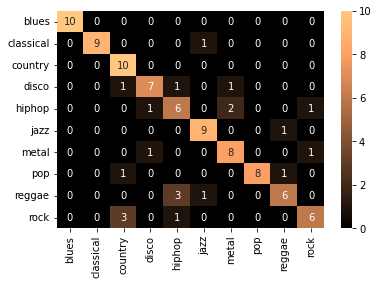

In [145]:
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
y_pred = xgb.predict(x_test)
print('Test Acc : ', accuracy_score(y_test, y_pred))
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, cmap = 'copper', xticklabels = le.classes_, yticklabels = le.classes_)
plt.show()

### **| 학습 - DNN**

In [172]:
# 딥러닝
x = layers.Input(57)
y = layers.Dense(128, activation = 'relu')(x)
y = layers.Dense(64, activation = 'relu')(y)
y = layers.Dropout(0.3)(y)
y = layers.Dense(32, activation = 'relu')(y)
y = layers.Dense(10, activation = 'softmax')(y)
model = models.Model(x,y)
model.summary()

Model: "model_20"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_26 (InputLayer)       [(None, 57)]              0         
                                                                 
 dense_93 (Dense)            (None, 128)               7424      
                                                                 
 dense_94 (Dense)            (None, 64)                8256      
                                                                 
 dropout_35 (Dropout)        (None, 64)                0         
                                                                 
 dense_95 (Dense)            (None, 32)                2080      
                                                                 
 dense_96 (Dense)            (None, 10)                330       
                                                                 
Total params: 18,090
Trainable params: 18,090
Non-trainabl

In [173]:
from pandas.core.series import validate_bool_kwarg
, validation_curve
model.compile(optimizer ='adam', loss = 'sparse_categorical_crossentropy',
              metrics = ['acc'])
history = model.fit(x_train, y_train, epochs = 30,
                    validation_data = (x_test,y_test))

Epoch 1/30
29/29 [==============================] - 1s 8ms/step - loss: 2.1877 - acc: 0.2167 - val_loss: 1.9692 - val_acc: 0.3300
Epoch 2/30
29/29 [==============================] - 0s 3ms/step - loss: 1.8250 - acc: 0.3711 - val_loss: 1.5790 - val_acc: 0.4300
Epoch 3/30
29/29 [==============================] - 0s 3ms/step - loss: 1.5153 - acc: 0.4678 - val_loss: 1.3172 - val_acc: 0.5200
Epoch 4/30
29/29 [==============================] - 0s 4ms/step - loss: 1.2818 - acc: 0.5411 - val_loss: 1.1717 - val_acc: 0.5700
Epoch 5/30
29/29 [==============================] - 0s 3ms/step - loss: 1.1553 - acc: 0.5978 - val_loss: 1.0576 - val_acc: 0.6100
Epoch 6/30
29/29 [==============================] - 0s 4ms/step - loss: 1.0546 - acc: 0.6111 - val_loss: 1.0002 - val_acc: 0.6300
Epoch 7/30
29/29 [==============================] - 0s 3ms/step - loss: 0.9639 - acc: 0.6533 - val_loss: 0.8969 - val_acc: 0.7600
Epoch 8/30
29/29 [==============================] - 0s 3ms/step - loss: 0.9146 - acc: 0.70

In [170]:
model.evaluate(x_test,y_test)

4/4 [==============================] - 0s 3ms/step - loss: 0.6821 - acc: 0.7800


[0.6821224093437195, 0.7799999713897705]

Text(0, 0.5, 'Loss')

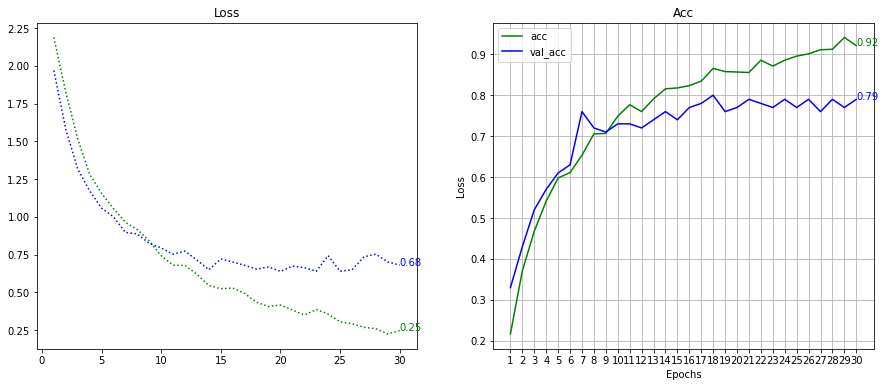

In [180]:
plt.figure(figsize = (15,6))

epochs = np.arange(1,31)
loss = history.history['loss']
val_loss = history.history['val_loss']
acc = history.history['acc']
val_acc = history.history['val_acc']

plt.subplot(121)
plt.plot(epochs, loss, linestyle = ':', label = f'train_loss', c = 'green')
plt.plot(epochs, val_loss, linestyle = ':', label = f'valid_loss', c = 'blue')
plt.title('Loss')
a, b = epochs[-1], loss[-1]
plt.text(a,b,np.round(b,2), c = 'green')
a, b = epochs[-1], val_loss[-1]
plt.text(a,b,np.round(b,2), c = 'blue')

plt.subplot(122)
plt.plot(epochs, acc, linestyle = '-', label = f'acc', c = 'green')
plt.plot(epochs, val_acc, linestyle = '-', label = f'val_acc', c = 'blue')
plt.title('Acc')
a, b = epochs[-1], acc[-1]
plt.text(a,b,np.round(b,2), c = 'green')
a, b = epochs[-1], val_acc[-1]
plt.text(a,b,np.round(b,2), c = 'blue')
plt.legend();plt.grid(True);plt.xticks(epochs)
plt.xlabel('Epochs');plt.ylabel('Loss')

## 딥러닝 접근 방법(Audio 원 데이터)
---